In [1]:
import jax.numpy as jnp
import jax
import matplotlib.pyplot as plt
import numpy as np
import os
import trimesh
import b3d
from jax.scipy.spatial.transform import Rotation as Rot
from b3d import Pose
#from b3d.utils import unproject_depth
import rerun as rr
import genjax
from tqdm import tqdm



In [2]:
image_width = 200
image_height = 200
fx = 200.0
fy = 200.0
cx = 100.0
cy = 100.0
near = 0.001
far = 16.0

def renderer():

    width = 200
    height = 200
    fx = 200.0
    fy = 200.0
    cx = 100.0
    cy = 100.0
    near = 0.001
    far = 16.0
    renderer = b3d.Renderer(width, height, fx, fy, cx, cy, near, far, 1024)
    return renderer

renderer = renderer()

renderer.set_intrinsics(image_width, image_height, fx, fy, cx, cy, near, far)

In [3]:
## approximate appearance model

#take surface normal

# object_library = b3d.MeshLibrary.make_empty_library()
# occluder = trimesh.creation.box(extents=jnp.array([0.0001, 0.1, 0.1]))
# occluder_colors = jnp.tile(jnp.array([0.8, 0.8, 0.8])[None,...], (occluder.vertices.shape[0], 1))
# object_library = b3d.MeshLibrary.make_empty_library()
# object_library.add_object(occluder.vertices, occluder.faces, attributes=occluder_colors)

mesh_path = os.path.join(
    b3d.get_root_path(), "assets/shared_data_bucket/025_mug/textured.obj"
)
mesh = trimesh.load(mesh_path)
mesh.vertices = mesh.vertices - mesh.vertices.mean(axis=0)

object_library = b3d.MeshLibrary.make_empty_library()
object_library.add_trimesh(mesh)

/opt/conda/envs/b3d/lib/python3.11/site-packages/trimesh/grouping.py:99: RuntimeWarning: invalid value encountered in cast
  stacked = np.column_stack(stacked).round().astype(np.int64)


In [4]:
flat_pose = b3d.Pose.from_position_and_target(
    jnp.array([0.3, 0.0, 0.0]), jnp.array([0.0, 0.0, 0.0]), jnp.array([0.0, 0.0, 1.0])
).inv()

from b3d.pose import from_axis_angle

transform_vec = jax.vmap(from_axis_angle, (None, 0))
in_place_rots = transform_vec(jnp.array([0,0,1]), jnp.linspace(0, jnp.pi/2, 10))

in_place_rots = transform_vec(jnp.array([0,0,1]), jnp.linspace(0, jnp.pi/2, 10))
tilt_pose = flat_pose @ in_place_rots[5]

rgb_tilt, depth_tilt = renderer.render_attribute(
    tilt_pose[None, ...],
    object_library.vertices,
    object_library.faces,
    object_library.ranges,
    object_library.attributes,
)

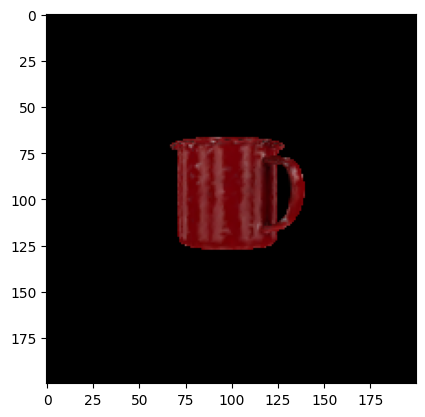

In [5]:
plt.imshow(rgb_tilt)

In [6]:
uvs, object_ids, triangle_ids, zs = renderer.rasterize_many(
            tilt_pose[None, None,...],
            object_library.vertices,
            object_library.faces,
            object_library.ranges,
        )

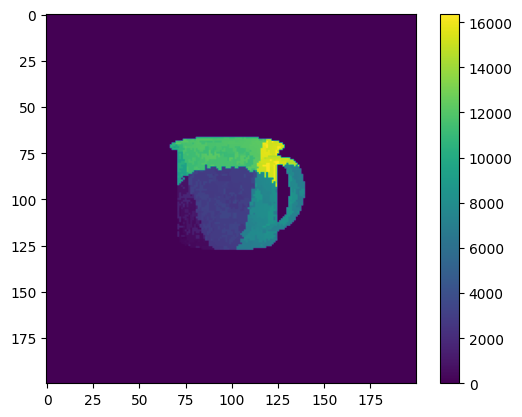

In [7]:
plt.imshow(triangle_ids[0])
plt.colorbar()

In [8]:
rgbs_mod, ds_mod, norm_im = renderer.render_attribute_normal(
    tilt_pose[None, ...],
    object_library.vertices,
    object_library.faces,
    object_library.ranges,
    object_library.attributes,
)

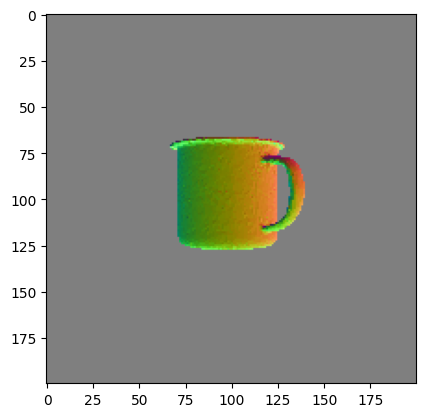

In [9]:
plt.imshow((norm_im+1)/2)

In [10]:
in_place_rots = transform_vec(jnp.array([0,0,1]), jnp.linspace(0, jnp.pi/2, 10))
tilt_poses = flat_pose @ in_place_rots

rgbs_mod, ds_mod, norm_im = renderer.render_attribute_normal_many(
    tilt_poses[:,None,...],
    object_library.vertices,
    object_library.faces,
    object_library.ranges,
    object_library.attributes,
)

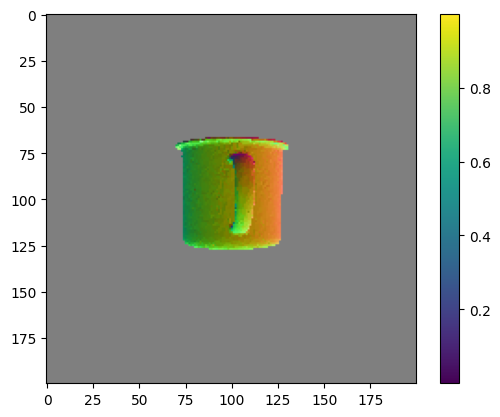

In [11]:
plt.imshow((norm_im[1]+1)/2)
plt.colorbar()

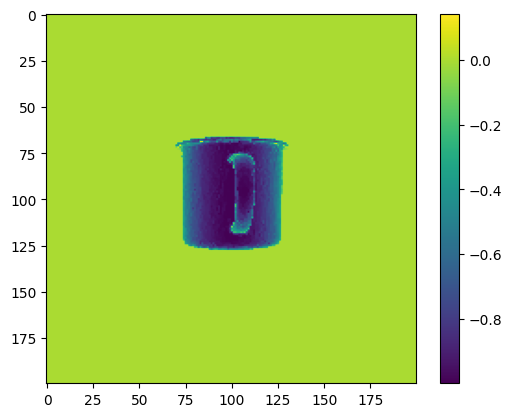

In [12]:
plt.imshow(norm_im[1,:,:,2])
plt.colorbar()

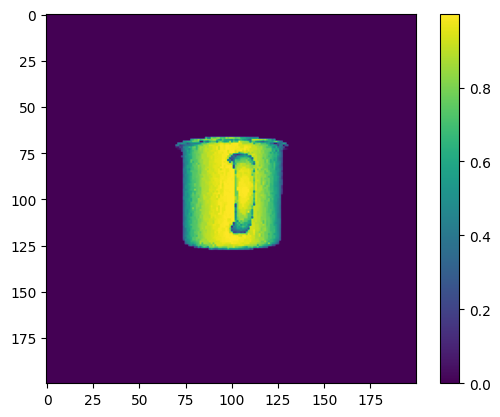

In [13]:
plt.imshow(jnp.abs(norm_im[1] @ jnp.array([0,0,1])))
plt.colorbar()

In [14]:
mesh_path = os.path.join(
    b3d.get_root_path(),
    "assets/shared_data_bucket/ycb_video_models/models/003_cracker_box/textured_simple.obj",
)
mesh = trimesh.load(mesh_path)

object_library = b3d.MeshLibrary.make_empty_library()
object_library.add_trimesh(mesh)

pose = b3d.Pose.from_position_and_target(
    jnp.array([0.2, 0.2, 0.2]), jnp.array([0.0, 0.0, 0.0])
).inv()

rgb, depth, normal = renderer.render_attribute_normal(
    pose[None, ...],
    object_library.vertices,
    object_library.faces,
    jnp.array([[0, len(object_library.faces)]]),
    object_library.attributes,
)

b3d.get_rgb_pil_image((normal+1)/2).save(b3d.get_root_path() / "assets/test_results/test_ycb_normal.png")

point_im = b3d.utils.unproject_depth(depth, renderer)

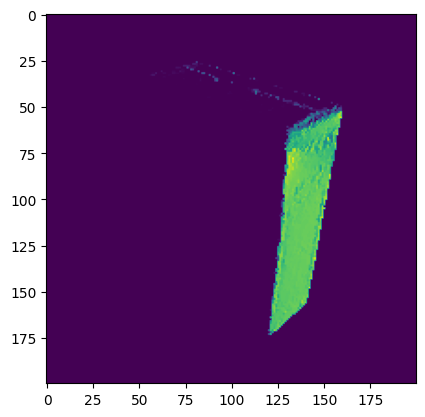

In [34]:
plt.imshow(jnp.clip(normal @ jnp.array([1,0,0]),0))

In [ ]:
# convexity under self-occlusion

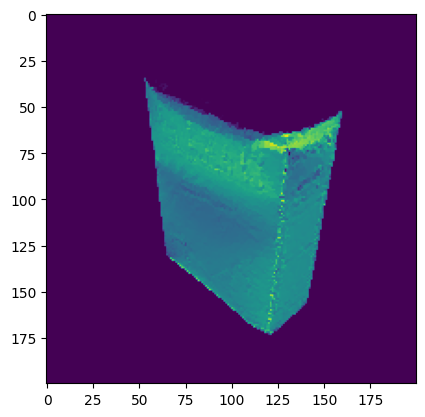

In [20]:
plt.imshow(jnp.clip(normal @ jnp.array([0,1,0]), 0))

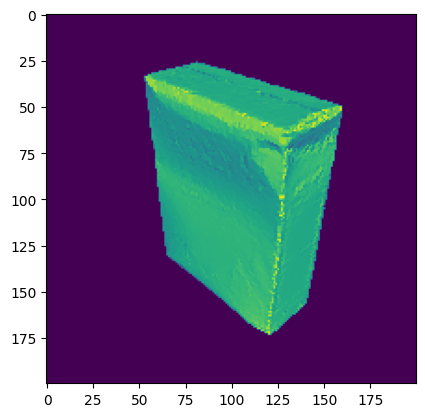

In [31]:
plt.imshow(jnp.clip(normal @ jnp.array([0,0,-1]), a_min=0))

In [32]:
# which way is the illumination supposed to go?

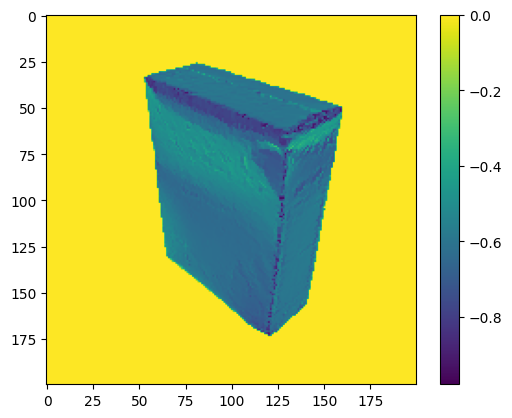

In [30]:
plt.imshow(normal @ jnp.array([0,0,1]))
plt.colorbar()